# TinyMS MobileNetV2 教程

在本教程中，我们会演示使用TinyMS API进行训练/推理一个MobileNetV2模型过程。

## 环境要求
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## 介绍

TinyMS是一个高级API，目的是让新手用户能够更加轻松地上手深度学习。TinyMS可以有效地减少用户在构建、训练、验证和推理一个模型过程中的操作次数。TinyMS也提供了教程和文档帮助开发者更好的上手和开发。

本教程中，包含6个步骤：`构建模型`、`下载数据集`、`训练模型`、`定义servable.json`、`启动服务器`和`推理`，其中服务器在子进程中启动。

In [1]:
import os
import json

from PIL import Image
from tinyms import context
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.model import Model, mobilenetv2
from tinyms.data import Cifar10Dataset, download_dataset
from tinyms.vision import cifar10_transform, ImageViewer
from tinyms.metrics import Accuracy
from tinyms.optimizers import Momentum
from tinyms.losses import CrossEntropyWithLabelSmooth
from tinyms.utils.train.loss_manager import FixedLossScaleManager
from tinyms.utils.train.lr_generator import mobilenetv2_lr
from tinyms.utils.train.cb_config import mobilenetv2_cb

[WARNING] ME(10671:140590521530176,MainProcess):2021-03-19-15:08:41.425.705 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. 构建模型

TinyMS封装了MindSpore MobileNetV2模型中的init和construct函数，代码行数能够大大减少，原有的大量代码段行数会被极限压缩:

In [2]:
# 构建模型
net = mobilenetv2(class_num=10, is_training=True)
model = Model(net)

### 2. 下载数据集

如果根目录下没有创建`cifar10`文件夹则[cifar10](http://www.cs.toronto.edu/~kriz/cifar.html)数据集会被自动下载并存放到根目录，如果`cifar10`文件夹已经存在于根目录 ，则此步操作会被跳过

In [3]:
# download the dataset
cifar10_path = '/root/cifar10/cifar-10-batches-bin'
if not os.path.exists(cifar10_path):
    download_dataset('cifar10', '/root')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************** Downloading the Cifar10 dataset **************
[██████████████████████████████████████████████████████████████████████████████████████████████████  ] 98.12%************Download complete*************


### 3. 训练模型

数据集中的训练集、验证集都会在此步骤中定义，同时也会定义训练参数。训练后生成的ckpt文件会保存到`/etc/tinyms/serving/mobilenetv2`文件夹以便后续使用，训练完成后会进行验证并输出 `Accuracy`指标。
```
提示：训练过程非常漫长，建议跳过训练步骤并直接下载、使用本教程提供的ckpt文件进行后续的推理
```

In [ ]:
# 检查mobilenetv2路径
ckpt_folder = '/etc/tinyms/serving/mobilenetv2'
ckpt_path = '/etc/tinyms/serving/mobilenetv2/mobilenetv2.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/mobilenetv2
else:
    print('mobilenetv2 ckpt folder already exists')

# 设置参数
epoch_size = 60 # default is 60
batch_size = 32
class_num = 10

# 设置环境参数
device_target="CPU"
dataset_sink_mode = False
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

# 创建数据集
train_dataset = Cifar10Dataset(cifar10_path, num_parallel_workers=4, shuffle=True)
train_dataset = cifar10_transform.apply_ds(train_dataset, repeat_size=1, batch_size=32, is_training=True)
eval_dataset = Cifar10Dataset(cifar10_path, num_parallel_workers=4, shuffle=True)
eval_dataset = cifar10_transform.apply_ds(eval_dataset, repeat_size=1, batch_size=32, is_training=False)
step_size = train_dataset.get_dataset_size()

# 定义loss函数
label_smooth = 0.1
loss = CrossEntropyWithLabelSmooth(smooth_factor=label_smooth,num_classes=class_num)

# 定义学习率
lr_max = 0.001
lr_init_scale = 0.01
lr_end_scale = 0.01
lr = mobilenetv2_lr(global_step=0,
                    lr_init=lr_max*lr_init_scale,
                    lr_end=lr_max*lr_end_scale,
                    lr_max=lr_max,
                    warmup_epochs=2,
                    total_epochs=epoch_size,
                    steps_per_epoch=step_size)

# 定义optimizer
loss_scale = FixedLossScaleManager(1024, drop_overflow_update=False)
opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()),lr, 0.9, 4e-5, 1024)
model.compile(loss_fn=loss, optimizer=opt, metrics={"Accuracy": Accuracy()},loss_scale_manager=loss_scale)

# configure checkpoint to save weights and do training job
save_checkpoint_epochs = 10
ckpoint_cb = mobilenetv2_cb(device_target=device_target,
                            lr=lr,
                            is_saving_checkpoint=True,
                            save_checkpoint_epochs=save_checkpoint_epochs,
                            step_size=step_size)


print('************************Start training*************************')
model.train(epoch_size, train_dataset, callbacks=ckpoint_cb, dataset_sink_mode=dataset_sink_mode)
model.save_checkpoint(ckpt_path)
print('************************Finished training*************************')

model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

```
提示：如果跳过了训练步骤，下载预训练的ckpt文件并继续推理步骤
```
点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/mobilenetv2.ckpt)进行下载，并将ckpt文件保存到`/etc/tinyms/serving/mobilenetv2/mobilenetv2.ckpt`

或者运行以下代码下载 `mobilenetv2` ckpt文件：

In [4]:
mobilenetv2_ckpt_folder = '/etc/tinyms/serving/mobilenetv2'
mobilenetv2_ckpt_path = '/etc/tinyms/serving/mobilenetv2/mobilenetv2.ckpt'

if not os.path.exists(mobilenetv2_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/mobilenetv2
    !wget -P /etc/tinyms/serving/mobilenetv2 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/mobilenetv2.ckpt
else:
    print('mobilenetv2 ckpt folder already exists')
    if not os.path.exists(mobilenetv2_ckpt_path):
        !wget -P /etc/tinyms/serving/mobilenetv2 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/mobilenetv2.ckpt
    else:
        print('mobilenetv2 ckpt file already exists')

mobilenetv2 ckpt folder already exists
--2021-03-19 15:10:50--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/mobilenetv2.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.90, 49.4.112.113, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18509001 (18M) [binary/octet-stream]
Saving to: ‘/etc/tinyms/serving/mobilenetv2/mobilenetv2.ckpt’

mobilenetv2.ckpt    100%[===================>]  17.65M  16.3MB/s    in 1.1s    

2021-03-19 15:10:51 (16.3 MB/s) - ‘/etc/tinyms/serving/mobilenetv2/mobilenetv2.ckpt’ saved [18509001/18509001]



### 4. 定义servable.json

运行下列代码定义servable json文件：

In [5]:
servable_json = [{'name': 'mobilenetv2', 
                  'description': 'This servable hosts a mobilenetv2 model predicting 10 classes of objects', 
                  'model': {
                      "name": "mobilenetv2", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. 启动服务器

#### 5.1 介绍
TinyMS推理是C/S（Client/Server）架构。TinyMS使用[Flask](https://flask.palletsprojects.com/en/1.1.x/)这个轻量化的网页服务器架构作为C/S通讯的基础架构。为了能够对模型进行推理，用户必须首先启动服务器。如果成功启动，服务器会在子进程中运行并且会监听从地址127.0.0.1，端口号5000发送来的POST请求并且使用MindSpore作为后端来处理这些请求。后端会构建模型，运行推理并且返回结果给客户端

#### 5.2 启动服务器
运行下列代码以启动服务器：

In [6]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 6. 推理

#### 6.1 上传图片

用户需要上传一张图片作为输入，图片中要求含有以下类别的物体以供识别：
```
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```
点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg)下载本教程中使用的图片。上传图片，如果使用命令行终端，可以使用'scp'或者'wget'获取图片，如果使用Jupyter，点击菜单右上方的'Upload'按钮并且选择上传的图片。将图片保存在根目录下，重命名为'airplane.jpg'(或其他自定义名字)。

或者运行下列代码下载本教程使用的图片：

In [7]:
# 下载飞机的图片
if not os.path.exists('/root/airplane.jpg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
else:
    print('airplane.jpg already exists')

--2021-03-19 15:10:59--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.90, 49.4.112.113, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151188 (148K) [image/jpeg]
Saving to: ‘/root/airplane.jpg’

airplane.jpg        100%[===================>] 147.64K   706KB/s    in 0.2s    

2021-03-19 15:11:00 (706 KB/s) - ‘/root/airplane.jpg’ saved [151188/151188]



#### 6.2 List servables

使用`list_servables`函数检查当前后端的serving模型

In [8]:
list_servables()

[{'description': 'This servable hosts a mobilenetv2 model predicting 10 classes of objects',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'mobilenetv2'},
  'name': 'mobilenetv2'}]

如果输出的`description`字段显示这是一个`mobilenetv2`的模型，则可以继续到下一步发送推理请求

#### 6.3 发送推理请求

运行`predict`函数发送推理请求，目前支持`TOP1_CLASS`或`TOP5_CLASS`输出策略

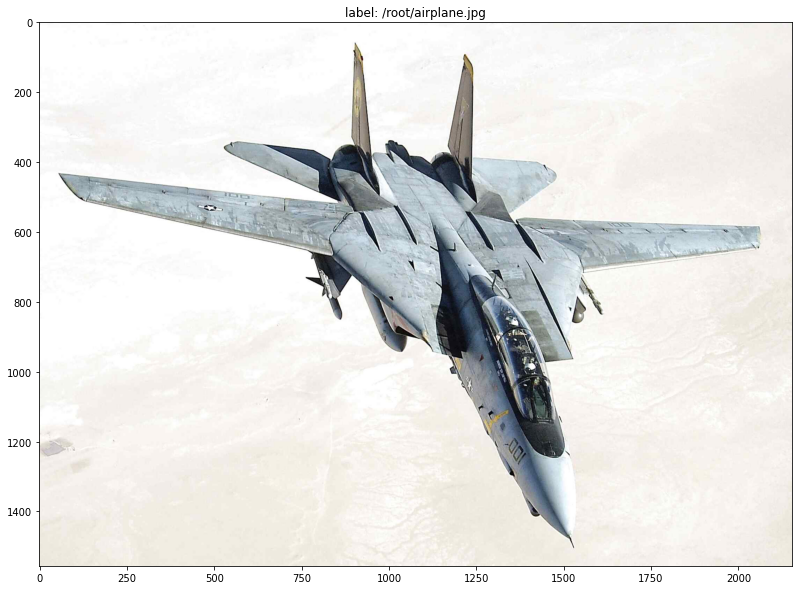

TOP1: airplane, score: 0.22268821299076080322


In [9]:
# 设置图片路径和输出策略（在TOP1_CLASS和TOP5_CLASS中选择一个）
image_path = "/root/airplane.jpg"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset_name, strategy)
if server_started() is True:
    img_viewer = ImageViewer(Image.open(image_path), image_path)
    img_viewer.show()
    print(predict(image_path, 'mobilenetv2', 'cifar10', strategy))
else:
    print("Server not started")

## 检查输出

如果看到了类似如下的输出：
```
TOP1: airplane, score: 0.22268821299076080322
```
则表明已经成功进行了一次的推理

## 关闭服务器

In [10]:
shutdown()

'Server shutting down...'